# =============================================================
# MILESTONE 2: Advanced Data Analysis and Feature Engineering
# =============================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from scipy import stats
from scipy.stats import chi2_contingency

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# Styling
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_PATH    = PROJECT_ROOT / "data" / "processed" / "final_processed_data.csv"
CLEANED_PATH = PROJECT_ROOT / "data" / "processed" / "cleaned_data.csv"   # for State decoding
STATIC_VIZ   = PROJECT_ROOT / "visualizations" / "static"
INTER_VIZ    = PROJECT_ROOT / "visualizations" / "interactive"

STATIC_VIZ.mkdir(parents=True, exist_ok=True)
INTER_VIZ.mkdir(parents=True, exist_ok=True)

In [4]:
df = pd.read_csv(DATA_PATH)
print(f"Final dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Churn rate: {df['Churn'].mean():.2%}")

X = df.drop("Churn", axis=1)
y = df["Churn"]

print("\nSelected columns:")
print(", ".join(X.columns.tolist()))

Final dataset: 3,333 rows × 21 columns
Churn rate: 14.49%

Selected columns:
Account length, Number vmail messages, Total day minutes, Total day calls, Total eve minutes, Total night minutes, Total intl minutes, Total intl calls, Customer service calls, Total_Minutes, Intl_Minutes_per_Call, Vmail_Rate, Day_Night_Ratio, International plan_Yes, Avg_Daily_Usage, Call_Frequency, Intl_Usage_Rate, log_Total_Minutes, log_Avg_Daily_Usage, log_Call_Frequency


In [5]:
# Load the original cleaned file that still contains all State_* columns
df_clean = pd.read_csv(CLEANED_PATH)

state_cols = [c for c in df_clean.columns if c.startswith("State_")]
if state_cols:
    df["State"] = df_clean[state_cols].idxmax(axis=1).str.replace("State_", "")
else:
    df["State"] = "N/A"
print("State column added/checked")

State column added/checked


# Statistical Significance Tests

In [6]:
print("### T-Test: Numerical Features (Churned vs Not Churned)")
print("="*80)

sig_num = []
for col in X.select_dtypes(include=[np.number]).columns:
    churned = X[col][y == 1]
    not_churned = X[col][y == 0]
    t_stat, p_val = stats.ttest_ind(churned, not_churned, equal_var=False, nan_policy='omit')
    sig = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{col:<30}: t={t_stat:6.3f}, p={p_val:.6f} → {sig}")
    if p_val < 0.05:
        sig_num.append(col)

print(f"\nSignificant numerical features: {len(sig_num)}")

### T-Test: Numerical Features (Churned vs Not Churned)
Account length                : t= 0.948, p=0.343334 → Not Significant
Number vmail messages         : t=-5.821, p=0.000000 → Significant
Total day minutes             : t= 9.697, p=0.000000 → Significant
Total day calls               : t= 1.087, p=0.277313 → Not Significant
Total eve minutes             : t= 5.234, p=0.000000 → Significant
Total night minutes           : t= 2.205, p=0.027796 → Significant
Total intl minutes            : t= 3.793, p=0.000163 → Significant
Total intl calls              : t=-3.402, p=0.000709 → Significant
Customer service calls        : t= 7.589, p=0.000000 → Significant
Total_Minutes                 : t=10.301, p=0.000000 → Significant
Intl_Minutes_per_Call         : t= 5.741, p=0.000000 → Significant
Vmail_Rate                    : t=-5.580, p=0.000000 → Significant
Day_Night_Ratio               : t= 5.637, p=0.000000 → Significant
International plan_Yes        : t=10.376, p=0.000000 → Significan

In [7]:
print("\n### Chi-Square: Categorical Features")
print("="*80)

sig_cat = []
cat_cols = [c for c in X.columns if any(prefix in c for prefix in ['State_', 'plan_Yes', 'Area code'])]
for col in cat_cols:
    contingency = pd.crosstab(X[col], y)
    chi2, p, _, _ = chi2_contingency(contingency)
    sig = "Significant" if p < 0.05 else "Not Significant"
    print(f"{col:<35}: χ²={chi2:6.1f}, p={p:.6f} → {sig}")
    if p < 0.05:
        sig_cat.append(col)

print(f"\nSignificant categorical features: {len(sig_cat)}")


### Chi-Square: Categorical Features
International plan_Yes             : χ²= 222.6, p=0.000000 → Significant

Significant categorical features: 1


# RFE Feature Importance

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12364\935588679.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette="viridis")


Static plot saved → f:\Projects\Portfolio\customer-churn-prediction-analysis\visualizations\static\feature_importance.png


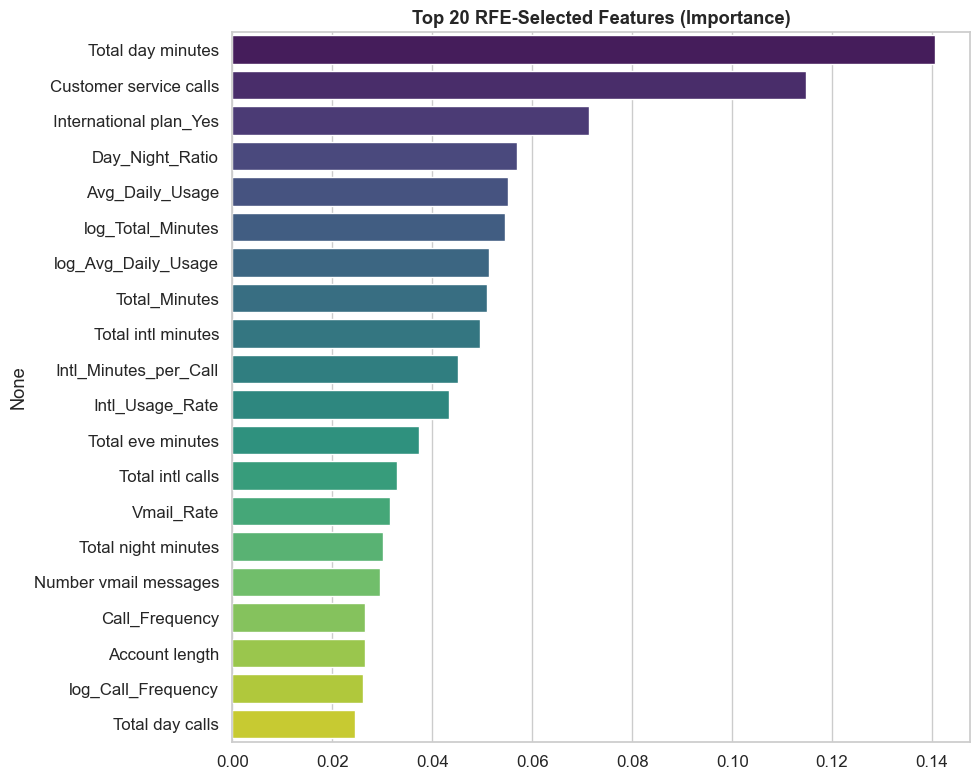

In [10]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)  # imp defined

plt.figure(figsize=(10, 8))
sns.barplot(x=imp.values, y=imp.index, palette="viridis")
plt.title("Top 20 RFE-Selected Features (Importance)", fontweight="bold")
plt.tight_layout()

save_path = STATIC_VIZ / "feature_importance.png"
plt.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"Static plot saved → {save_path}")
plt.show()

# Interactive Churn Dashboard

In [ ]:
colors = {0: "#1f77b4", 1: "#ff4040"}

# Safe feature selection
available_features = df.columns.tolist()
top1 = imp.index[0] if imp.index[0] in available_features else available_features[0]
top2 = imp.index[1] if len(imp) > 1 and imp.index[1] in available_features else available_features[1]

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Churn Distribution", "Top 10 States by Churn Rate", 
        f"Distribution: {top1}", f"{top1} vs {top2}",
        "Tenure by Churn", "Service Calls Impact"
    ),
    specs=[
        [{"type": "domain"}, {"type": "bar"}],
        [{"type": "histogram"}, {"type": "scatter"}],
        [{"type": "box"}, {"type": "bar"}]
    ]
)

# 1. Churn Distribution Pie Chart
churn_counts = y.value_counts().sort_index()
fig.add_trace(
    go.Pie(
        labels=["No Churn", "Churn"],
        values=churn_counts.values,
        marker_colors=list(colors.values()),
        textinfo='label+percent',
        hovertemplate='%{label}: %{value}<br>%{percent}<extra></extra>'
    ),
    row=1, col=1
)

# 2. Top States by Churn Rate
state_cols = [c for c in df.columns if c.startswith("State_")]
if state_cols:
    # Get original state names from one-hot encoded columns
    state_data = []
    for col in state_cols:
        state_name = col.replace("State_", "")
        state_mask = df[col] == 1
        if state_mask.sum() > 0:
            churn_rate = y[state_mask].mean()
            state_data.append({"State": state_name, "Churn_Rate": churn_rate, "Count": state_mask.sum()})
    
    if state_data:
        state_df = pd.DataFrame(state_data).sort_values("Churn_Rate", ascending=False).head(10)
        fig.add_trace(
            go.Bar(
                x=state_df["State"], 
                y=state_df["Churn_Rate"] * 100,
                text=[f"{v:.1f}%" for v in state_df["Churn_Rate"] * 100],
                textposition='outside',
                marker_color='#ff7f0e',
                hovertemplate='State: %{x}<br>Churn Rate: %{y:.1f}%<extra></extra>'
            ),
            row=1, col=2
        )
    else:
        fig.add_annotation(text="No State Data Available", x=0.5, y=0.5, 
                          xref="x2", yref="y2", showarrow=False, font=dict(size=14))
else:
    fig.add_annotation(text="No State Features Found", x=0.5, y=0.5, 
                      xref="x2", yref="y2", showarrow=False, font=dict(size=14))

# 3. Distribution of Top Feature
fig.add_trace(
    go.Histogram(
        x=df[top1], 
        nbinsx=30,
        marker_color='#2ca02c',
        name=top1,
        hovertemplate='Value: %{x}<br>Count: %{y}<extra></extra>'
    ),
    row=2, col=1
)

# 4. Scatter: Top 2 Features
fig.add_trace(
    go.Scatter(
        x=df[top1], 
        y=df[top2], 
        mode="markers",
        marker=dict(
            color=y, 
            colorscale=[[0, colors[0]], [1, colors[1]]],
            size=5,
            opacity=0.6,
            line=dict(width=0.5, color='white')
        ),
        hovertemplate=f'{top1}: %{{x}}<br>{top2}: %{{y}}<br>Churn: %{{marker.color}}<extra></extra>'
    ),
    row=2, col=2
)

# 5. Tenure Distribution by Churn
tenure_col = None
for possible_name in ["Customer_tenure_months", "Account length", "account_length"]:
    if possible_name in df.columns:
        tenure_col = possible_name
        break

if tenure_col:
    fig.add_trace(
        go.Box(
            y=df[tenure_col], 
            x=y.map({0: "No Churn", 1: "Churn"}),
            marker_color='#d62728',
            boxmean='sd',
            hovertemplate='%{x}<br>Value: %{y}<extra></extra>'
        ),
        row=3, col=1
    )
else:
    fig.add_annotation(text="No Tenure Feature Available", x=0.5, y=0.5, 
                      xref="x5", yref="y5", showarrow=False, font=dict(size=14))

# 6. Service Calls Impact
service_col = None
for possible_name in ["High_Service_Calls", "Customer service calls", "customer_service_calls"]:
    if possible_name in df.columns:
        service_col = possible_name
        break

if service_col:
    if service_col == "High_Service_Calls":
        # Binary feature
        service_churn = df.groupby(service_col)["Churn"].mean() if "Churn" in df.columns else y.groupby(df[service_col]).mean()
        labels = ["Low (≤3)", "High (>3)"]
    else:
        # Numeric feature - create bins
        df_temp = df.copy()
        df_temp['service_category'] = pd.cut(df_temp[service_col], 
                                             bins=[-np.inf, 3, np.inf], 
                                             labels=["Low (≤3)", "High (>3)"])
        service_churn = y.groupby(df_temp['service_category']).mean()
        labels = service_churn.index.tolist()
    
    fig.add_trace(
        go.Bar(
            x=labels,
            y=service_churn.values * 100,
            text=[f"{v:.1f}%" for v in service_churn.values * 100],
            textposition='outside',
            marker_color='#9467bd',
            hovertemplate='%{x}<br>Churn Rate: %{y:.1f}%<extra></extra>'
        ),
        row=3, col=2
    )
else:
    fig.add_annotation(text="No Service Call Feature Available", x=0.5, y=0.5, 
                      xref="x6", yref="y6", showarrow=False, font=dict(size=14))

# Update layout
fig.update_layout(
    height=1000, 
    title_text="Customer Churn Analysis Dashboard",
    title_font_size=20,
    showlegend=False,
    template="plotly_white"
)

# Update axes labels
fig.update_xaxes(title_text="State", row=1, col=2)
fig.update_yaxes(title_text="Churn Rate (%)", row=1, col=2)

fig.update_xaxes(title_text=top1, row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)

fig.update_xaxes(title_text=top1, row=2, col=2)
fig.update_yaxes(title_text=top2, row=2, col=2)

fig.update_xaxes(title_text="Churn Status", row=3, col=1)
fig.update_yaxes(title_text="Tenure (months)" if tenure_col else "Value", row=3, col=1)

fig.update_xaxes(title_text="Service Calls", row=3, col=2)
fig.update_yaxes(title_text="Churn Rate (%)", row=3, col=2)

# Save and display
fig.write_html(INTER_VIZ / "churn_dashboard.html")
print(f"Dashboard saved to: {INTER_VIZ / 'churn_dashboard.html'}")
fig.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12364\459942474.py:138: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Dashboard saved to: f:\Projects\Portfolio\customer-churn-prediction-analysis\visualizations\interactive\churn_dashboard.html


In [16]:
out_dir = str(INTER_VIZ)

# 1. Avg Daily Usage Histogram
if "Avg_Daily_Usage" in df.columns:
    f = px.histogram(df, x="Avg_Daily_Usage", color="Churn", nbins=40,
                     barmode="overlay", color_discrete_map=colors,
                     title="Avg Daily Usage by Churn")
    f.update_layout(template="plotly_white", height=600, width=800)
    f.show()
    f.write_html(os.path.join(out_dir, "daily_usage_histogram.html"))

# 2. Total Minutes vs Call Frequency
if {"Total_Minutes", "Call_Frequency"}.issubset(df.columns):
    f = px.scatter(df, x="Total_Minutes", y="Call_Frequency", color="Churn",
                   color_discrete_map=colors, opacity=0.6,
                   title="Total Minutes vs Call Frequency")
    f.update_layout(template="plotly_white", height=600, width=800)
    f.show()
    f.write_html(os.path.join(out_dir, "total_minutes_vs_call_frequency.html"))

# 3. Tenure Box (extra copy)
if "Customer_tenure_months" in df.columns:
    f = px.box(df, x="Churn", y="Customer_tenure_months", color="Churn",
               color_discrete_map=colors, title="Customer Tenure by Churn")
    f.update_layout(template="plotly_white", height=600, width=800)
    f.show()
    f.write_html(os.path.join(out_dir, "tenure_box_extra.html"))

# 4. Daily Minutes vs Daily Calls
if {"Total day minutes", "Total day calls"}.issubset(df.columns):
    f = px.scatter(df, x="Total day minutes", y="Total day calls",
                   color="Churn", color_discrete_map=colors,
                   title="Daily Minutes vs Daily Calls")
    f.update_layout(template="plotly_white", height=600, width=800)
    f.show()
    f.write_html(os.path.join(out_dir, "daily_minutes_vs_calls.html"))

# 5. Churn Rate by Tenure Group
if "Customer_tenure_months" in df.columns:
    df_temp = df.copy()
    df_temp["Tenure_Group"] = pd.qcut(df_temp["Customer_tenure_months"], 5,
                                     labels=["VL","L","M","H","VH"])
    churn_rate = df_temp.groupby("Tenure_Group")["Churn"].mean().reset_index()
    f = px.line(churn_rate, x="Tenure_Group", y="Churn", markers=True,
                title="Churn Rate by Tenure Group",
                color_discrete_sequence=[colors[1]])
    f.update_layout(template="plotly_white", height=600, width=800)
    f.show()
    f.write_html(os.path.join(out_dir, "tenure_churn_rate.html"))

# 6. Correlation Heatmap
num_cols = X.select_dtypes(include=[np.number]).columns
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    f = px.imshow(corr, text_auto=".2f", color_continuous_scale="RdBu_r",
                  title="Correlation Heatmap")
    f.update_layout(template="plotly_white", height=700, width=900)
    f.show()
    f.write_html(os.path.join(out_dir, "correlation_heatmap.html"))